In [1]:
!pip install --quiet kaggle matplotlib seaborn scikit-learn xgboost optuna pandas

In [53]:
!pip install --quiet scikit-learn xgboost pandas numpy joblib imbalanced-learn pickle tabulate

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [55]:
!pip install tabulate

In [56]:
import os
import optuna
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
import xgboost as xgb
from tabulate import tabulate
import joblib
from IPython.display import display, Markdown



sns.set(style='whitegrid')

## Data Exploration

In [6]:
!mkdir -p ~/.kaggle

In [7]:
!mv kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0%|                                               | 0.00/66.0M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 66.0M/66.0M [00:00<00:00, 1.58GB/s]


In [10]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [5]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
print('shape:', df.shape)

shape: (284807, 31)


In [7]:
print('--- Missing values ---')
print(df.isnull().sum().sum())
print('\n--- Duplicates ---')
print('num duplicates:', df.duplicated().sum())
print('\n--- class distribution ---')
print(df['Class'].value_counts())
print(df['Class'].value_counts(normalize=True))

--- Missing values ---
0

--- Duplicates ---
num duplicates: 1081

--- class distribution ---
Class
0    284315
1       492
Name: count, dtype: int64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [14]:
# The classes are heavily skewed we need to solve this issue later.
print('None Fraudulent transactions:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Fraudulent transactions:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

None Fraudulent transactions: 99.83 % of the dataset
Fraudulent transactions: 0.17 % of the dataset


We must address the imbalance in our dataset. Since the vast majority of transactions are non-fraudulent, basing our analysis and models on this distribution will result in models that are highly biased. Our algorithms will perform poorly, not because they can't predict, but because they will fail to identify the rare fraud cases, effectively missing the entire goal of the exercise.

In [17]:
print(df.describe().T)

           count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.175161e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.384974e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.094852e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  1.021879e-15      1.380247 -113.743307     -0.691597   
V6      284807.0  1.494498e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.620335e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.149614e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.414189e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  2.238554e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  1.724421e-15      1.020713   -4.797473     -0.762494   
V12     284807.0 -1.245415e-15      0.

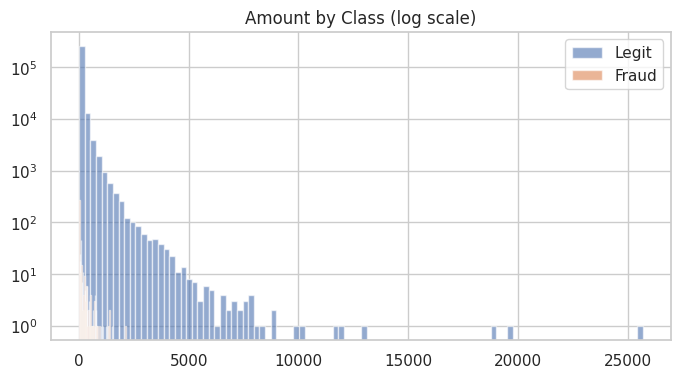

In [18]:
# Amount: fraud vs legit (log scale for better visibility)
plt.figure(figsize=(8,4))
plt.hist(df.loc[df['Class']==0,'Amount'], bins=100, alpha=0.6, label='Legit')
plt.hist(df.loc[df['Class']==1,'Amount'], bins=100, alpha=0.6, label='Fraud')
plt.yscale('log')
plt.legend()
plt.title('Amount by Class (log scale)')
plt.show()

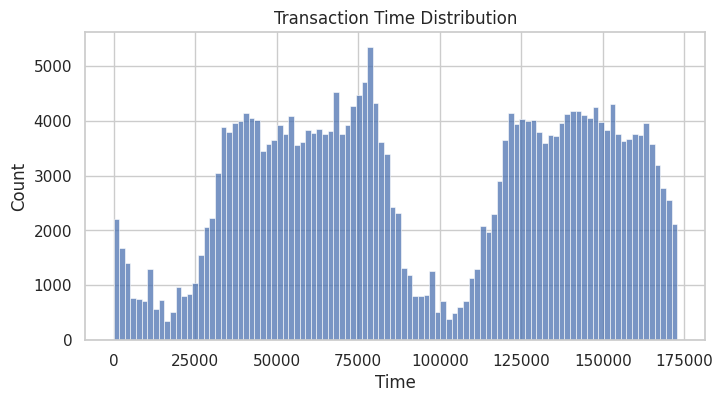

In [19]:
# Time distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Time'], bins=100)
plt.title('Transaction Time Distribution')
plt.show()

<Figure size 1000x600 with 0 Axes>

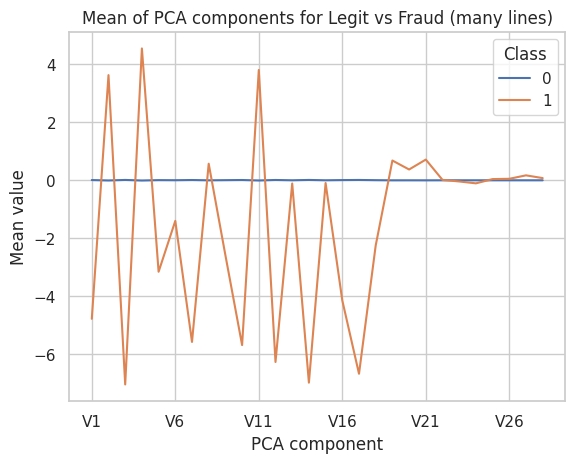

In [20]:
# Simple pairwise overview of PCA features vs Class - show mean of each V for fraud vs legit
pca_cols = [c for c in df.columns if c.startswith('V')]
means = df.groupby('Class')[pca_cols].mean().T
plt.figure(figsize=(10,6))
means.plot(kind='line')
plt.title('Mean of PCA components for Legit vs Fraud (many lines)')
plt.xlabel('PCA component')
plt.ylabel('Mean value')
plt.show()

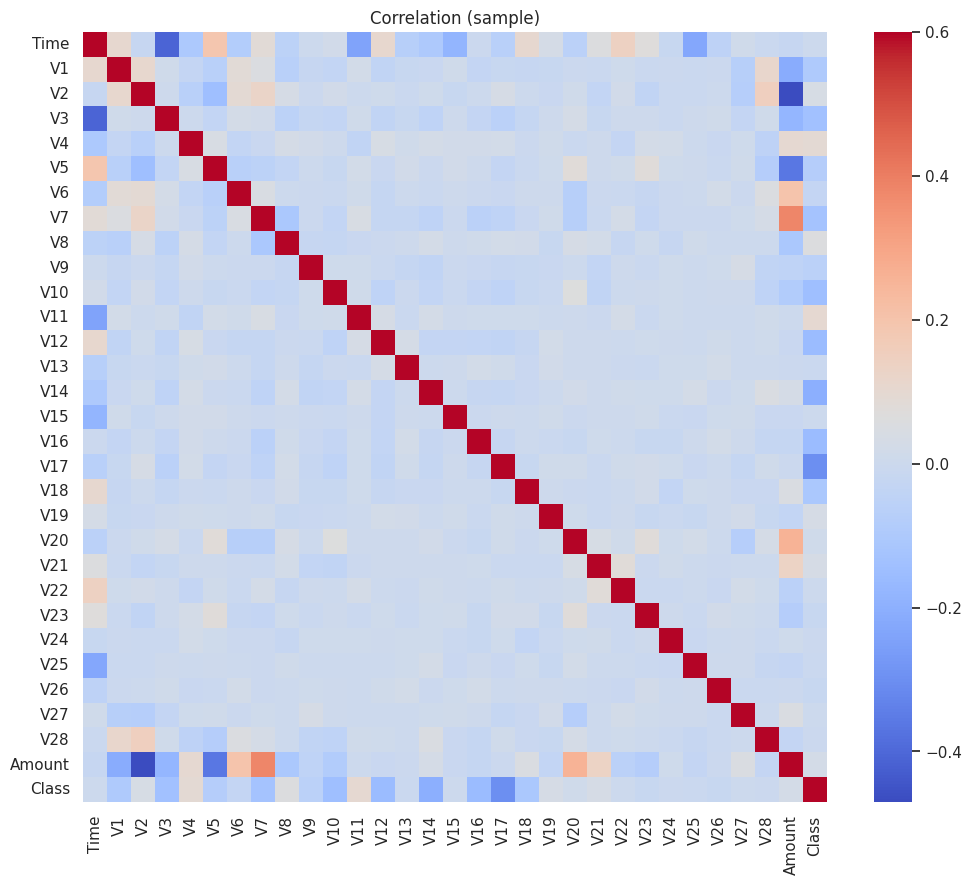

In [21]:
# Correlation heatmap (small sample to speed up)
sample = df.sample(n=10000, random_state=42)
plt.figure(figsize=(12,10))
sns.heatmap(sample.corr(), vmax=0.6, cmap='coolwarm')
plt.title('Correlation (sample)')
plt.show()

In [22]:
# ## Save a cleaned copy for training
# We'll add scaled features and hour here so that at training stage, we can load the prepared CSV.
# The 'Amount' and 'Time' columns need scaling, but the 'V' features are already PCA-transformed.

df_p = df.copy()
scaler = StandardScaler()
df_p['scaled_amount'] = scaler.fit_transform(df_p[['Amount']])
# use a separate scaler for time if you prefer
df_p['scaled_time'] = scaler.fit_transform(df_p[['Time']])

# drop originals optional
df_p = df_p.drop(['Time','Amount'], axis=1)
df_p.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


In [23]:
# Save prepared CSV
prepared_path = 'creditcard_prepared.csv'
df_p.to_csv(prepared_path, index=False)
print('Prepared CSV saved to', prepared_path)

Prepared CSV saved to creditcard_prepared.csv


#### Load prepared data on environment restarts

In [10]:
df_p = pd.read_csv("creditcard_prepared.csv")
df_p.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


## Model Training

In [11]:
# Features (X) and Target (y) separation

X = df_p.drop('Class', axis=1)
y = df_p['Class']

To manage the data imbalance, we need to employ techniques that either rebalance the training data or adjust the model's learning process. We will use Synthetic Minority Over-sampling Technique (SMOTE).

SMOTE works by taking a minority class sample and creating new, synthetic samples along the line segments connecting the selected sample with its nearest neighbors. This expands the minority class feature space without simply replicating data

In [12]:
# Stratified train/val/test split (use stratification to preserve imbalance ratio in test set)
# Split 1: Train/Val (80%) and Test (20%)

X_trainval, X_test, y_trainval, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42
)

# Split 2: Train (75% of X_trainval = 60% of total) and Val (25% of X_trainval = 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)

In [26]:
print("--- Dataset Sizes ---")
print(f"Total number of samples: {len(X)}")
print(f"Training set size (60%): {len(X_train)} samples")
print(f"Validation set size (20%): {len(X_val)} samples")
print(f"Test set size (20%): {len(X_test)} samples")

--- Dataset Sizes ---
Total number of samples: 284807
Training set size (60%): 170883 samples
Validation set size (20%): 56962 samples
Test set size (20%): 56962 samples


In [27]:
#Print the target distribution (Fraud/Non-Fraud) for each set
print("\n--- Target Class Distribution (Fraud/Non-Fraud) ---")
print("Train Set Class Count:")
print(y_train.value_counts())
print("\nValidation Set Class Count:")
print(y_val.value_counts())
print("\nTest Set Class Count:")
print(y_test.value_counts())


--- Target Class Distribution (Fraud/Non-Fraud) ---
Train Set Class Count:
Class
0    170588
1       295
Name: count, dtype: int64

Validation Set Class Count:
Class
0    56863
1       99
Name: count, dtype: int64

Test Set Class Count:
Class
0    56864
1       98
Name: count, dtype: int64


In [28]:
print("Class distribution BEFORE SMOTE:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

Class distribution BEFORE SMOTE:
Class
0    170588
1       295
Name: count, dtype: int64
Class
0    0.998274
1    0.001726
Name: proportion, dtype: float64


In [14]:
# Apply SMOTE ONLY to training set
sm = SMOTE(random_state=42, sampling_strategy="auto")
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [30]:
print("Class distribution AFTER SMOTE:")
print(y_train_res.value_counts())
print(y_train_res.value_counts(normalize=True))

Class distribution AFTER SMOTE:
Class
0    170588
1    170588
Name: count, dtype: int64
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [18]:
# Calculate class weights manually for LR
neg, pos = np.bincount(y_train)
class_weight_lr = {0: (1 / neg), 1: (1 / pos)}
print(f"Computed Logistic Regression class weights: {class_weight_lr}")

Computed Logistic Regression class weights: {0: np.float64(5.86207705114076e-06), 1: np.float64(0.003389830508474576)}


In [19]:
# Calculate scale_pos_weight for XGBoost
scale_pos_weight_value = neg / pos
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

Calculated scale_pos_weight: 578.26


### Logistic Regression

In [23]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_res, y_train_res)


val_proba_lr = lr.predict_proba(X_val)[:,1]
from sklearn.metrics import average_precision_score
print("Logistic Regression Validation Report:")
print(classification_report(y_val, lr.predict(X_val)))
pr_auc = average_precision_score(y_val, val_proba_lr)
roc_auc = roc_auc_score(y_val, val_proba_lr)

print(f"PR-AUC: {pr_auc:.4f}, ROC-AUC: {roc_auc:.4f}")

Logistic Regression Validation Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56863
           1       0.06      0.88      0.11        99

    accuracy                           0.97     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.97      0.99     56962

PR-AUC: 0.6809, ROC-AUC: 0.9718


### Random Forest 

In [15]:
rf = RandomForestClassifier(
    n_estimators=200, 
    class_weight='balanced', 
    n_jobs=-1, 
    random_state=42
)
rf.fit(X_train_res, y_train_res)

val_proba_rf = rf.predict_proba(X_val)[:, 1]

print("Random Forest Validation Report:")
print(classification_report(y_val, rf.predict(X_val)))

print("ROC AUC:", roc_auc_score(y_val, val_proba_rf))
print("PR-AUC:", average_precision_score(y_val, val_proba_rf))

Random Forest Validation Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.78      0.82        99

    accuracy                           1.00     56962
   macro avg       0.94      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9634469663662636
PR-AUC: 0.8074127264659297


### XGBoost

In [20]:
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dval = xgb.DMatrix(X_val, label=y_val)

d_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'eta': 0.1,
    'max_depth': 6,
    'scale_pos_weight': scale_pos_weight_value,
}

bst = xgb.train(
    d_params,
    dtrain,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    num_boost_round=300,
    early_stopping_rounds=20
)

val_proba_xgb = bst.predict(dval)

print("XGBoost Validation Report:")
print(classification_report(y_val, (val_proba_xgb > 0.5).astype(int)))
print("ROC AUC:", roc_auc_score(y_val, val_proba_xgb))
print("PR-AUC:", average_precision_score(y_val, val_proba_xgb))


[0]	train-aucpr:0.62724	eval-aucpr:0.00271
[1]	train-aucpr:0.63218	eval-aucpr:0.00277
[2]	train-aucpr:0.67307	eval-aucpr:0.00328
[3]	train-aucpr:0.90377	eval-aucpr:0.01320
[4]	train-aucpr:0.90607	eval-aucpr:0.01355
[5]	train-aucpr:0.90709	eval-aucpr:0.01373
[6]	train-aucpr:0.90995	eval-aucpr:0.01380
[7]	train-aucpr:0.91086	eval-aucpr:0.01395
[8]	train-aucpr:0.92012	eval-aucpr:0.01565
[9]	train-aucpr:0.92013	eval-aucpr:0.01565
[10]	train-aucpr:0.92014	eval-aucpr:0.01566
[11]	train-aucpr:0.92140	eval-aucpr:0.01593
[12]	train-aucpr:0.93096	eval-aucpr:0.01801
[13]	train-aucpr:0.93834	eval-aucpr:0.01988
[14]	train-aucpr:0.93882	eval-aucpr:0.02000
[15]	train-aucpr:0.93962	eval-aucpr:0.01988
[16]	train-aucpr:0.94280	eval-aucpr:0.02099
[17]	train-aucpr:0.94286	eval-aucpr:0.02099
[18]	train-aucpr:0.95625	eval-aucpr:0.02719
[19]	train-aucpr:0.97773	eval-aucpr:0.05471
[20]	train-aucpr:0.97832	eval-aucpr:0.05531
[21]	train-aucpr:0.97900	eval-aucpr:0.05627
[22]	train-aucpr:0.98140	eval-aucpr:0.0633

#### Compare LR, RF, and XGBoost Metrics

In [24]:
# Collect metrics in a dictionary
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "ROC-AUC": [
        roc_auc_score(y_val, val_proba_lr),
        roc_auc_score(y_val, val_proba_rf),
        roc_auc_score(y_val, val_proba_xgb)
    ],
    "PR-AUC": [
        average_precision_score(y_val, val_proba_lr),
        average_precision_score(y_val, val_proba_rf),
        average_precision_score(y_val, val_proba_xgb)
    ]
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Pretty formatting
print("\nModel Performance Comparison (Validation Set):")
print(results_df.to_string(index=False, float_format="%.4f"))


Model Performance Comparison (Validation Set):
              Model  ROC-AUC  PR-AUC
Logistic Regression   0.9718  0.6809
      Random Forest   0.9634  0.8074
            XGBoost   0.9476  0.7625


✔ PR-AUC (Precision–Recall AUC)

Because the dataset is highly imbalanced, and PR-AUC measures how well the model detects positives (fraud cases).

ROC-AUC is less reliable on imbalanced data.

Random Forest wins

It has the highest PR-AUC, meaning it produces the best precision/recall trade-off for fraud detection.

Even though LR has the highest ROC-AUC, that metric is misleading on imbalanced datasets.

In [30]:
!pip install pickle
import pickle
# Save models
os.makedirs('models', exist_ok=True)

# Logistic Regression
with open('models/lr.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Random Forest
with open('models/rf.pkl', 'wb') as f:
    pickle.dump(rf, f)

# XGBoost
bst.save_model('models/xgb.json')  # JSON format is human-readable and version-safe

print("All models saved successfully!")


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
All models saved successfully!


In [ ]:
# -----------------------------
# 2️⃣ Reload Models
# -----------------------------

# Logistic Regression
with open('models/lr.pkl', 'rb') as f:
    lr_loaded = pickle.load(f)

# Random Forest
with open('models/rf.pkl', 'rb') as f:
    rf_loaded = pickle.load(f)

# XGBoost
bst_loaded = xgb.Booster()
bst_loaded.load_model('models/xgb.json')

print("All models loaded successfully!")

## Optuna Tuning

In [35]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


### 1️⃣ Logistic Regression Tuning

In [36]:
def objective_lr(trial):
    # Suggest hyperparameters
    C = trial.suggest_loguniform('C', 0.01, 10)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Train model
    lr = LogisticRegression(
        C=C,
        solver=solver,
        max_iter=500,
        class_weight='balanced'
    )
    lr.fit(X_train_res, y_train_res)
    
    # Evaluate on validation set
    val_proba = lr.predict_proba(X_val)[:,1]
    pr_auc = average_precision_score(y_val, val_proba)
    return pr_auc  # maximize PR-AUC

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=10)  # minimal trials for Codespaces

print("Best LR params:", study_lr.best_params)
print("Best LR PR-AUC:", study_lr.best_value)


[I 2025-11-19 11:18:54,196] A new study created in memory with name: no-name-f954621b-e268-4205-b442-35728b3928fe
[I 2025-11-19 11:18:56,090] Trial 0 finished with value: 0.668338206030167 and parameters: {'C': 0.014475147303020394, 'solver': 'liblinear'}. Best is trial 0 with value: 0.668338206030167.
[I 2025-11-19 11:18:58,554] Trial 1 finished with value: 0.6757626624202949 and parameters: {'C': 0.08149051978089135, 'solver': 'liblinear'}. Best is trial 1 with value: 0.6757626624202949.
[I 2025-11-19 11:19:01,089] Trial 2 finished with value: 0.6739139832842163 and parameters: {'C': 1.1529919431351567, 'solver': 'liblinear'}. Best is trial 1 with value: 0.6757626624202949.
[I 2025-11-19 11:20:44,960] Trial 3 finished with value: 0.6740785046637763 and parameters: {'C': 2.246490770931273, 'solver': 'saga'}. Best is trial 1 with value: 0.6757626624202949.
[I 2025-11-19 11:22:08,232] Trial 4 finished with value: 0.6754601257682413 and parameters: {'C': 0.04049782008435051, 'solver': 's

Best LR params: {'C': 0.5294345352741391, 'solver': 'liblinear'}
Best LR PR-AUC: 0.6810216089903708


 ### 2️⃣ Random Forest Tuning

In [37]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train_res, y_train_res)
    
    val_proba = rf.predict_proba(X_val)[:,1]
    pr_auc = average_precision_score(y_val, val_proba)
    return pr_auc

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10)

print("Best RF params:", study_rf.best_params)
print("Best RF PR-AUC:", study_rf.best_value)

[I 2025-11-19 11:50:01,517] A new study created in memory with name: no-name-cf07377b-2c97-4da7-8410-7a362410e616
[I 2025-11-19 11:50:29,544] Trial 0 finished with value: 0.6327256263203589 and parameters: {'n_estimators': 198, 'max_depth': 2}. Best is trial 0 with value: 0.6327256263203589.
[I 2025-11-19 11:51:41,739] Trial 1 finished with value: 0.7322765674266614 and parameters: {'n_estimators': 129, 'max_depth': 9}. Best is trial 1 with value: 0.7322765674266614.
[I 2025-11-19 11:53:41,718] Trial 2 finished with value: 0.7568653120547015 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 2 with value: 0.7568653120547015.
[I 2025-11-19 11:54:39,436] Trial 3 finished with value: 0.7374614525500782 and parameters: {'n_estimators': 101, 'max_depth': 9}. Best is trial 2 with value: 0.7568653120547015.
[I 2025-11-19 11:55:35,571] Trial 4 finished with value: 0.7241330378845278 and parameters: {'n_estimators': 110, 'max_depth': 8}. Best is trial 2 with value: 0.75686531

Best RF params: {'n_estimators': 200, 'max_depth': 10}
Best RF PR-AUC: 0.7568653120547015


### 3️⃣ XGBoost Tuning

In [38]:
def objective_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'eta': trial.suggest_float('eta', 0.05, 0.2),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'verbosity': 0
    }
    
    dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=50,  # minimal rounds for speed
        evals=[(dval, 'val')],
        verbose_eval=False
    )
    
    val_proba = bst.predict(dval)
    pr_auc = average_precision_score(y_val, val_proba)
    return pr_auc

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=10)

print("Best XGB params:", study_xgb.best_params)
print("Best XGB PR-AUC:", study_xgb.best_value)

[I 2025-11-19 12:01:11,658] A new study created in memory with name: no-name-09897d70-47f7-4d91-a0bb-62ca3938e85a
[I 2025-11-19 12:01:12,900] Trial 0 finished with value: 0.7005824805143794 and parameters: {'eta': 0.1645317228192291, 'max_depth': 2, 'scale_pos_weight': 1.15985686757836}. Best is trial 0 with value: 0.7005824805143794.
[I 2025-11-19 12:01:14,740] Trial 1 finished with value: 0.7346993929645392 and parameters: {'eta': 0.11372877058510315, 'max_depth': 6, 'scale_pos_weight': 1.4151638821870118}. Best is trial 1 with value: 0.7346993929645392.
[I 2025-11-19 12:01:16,474] Trial 2 finished with value: 0.6624628065112141 and parameters: {'eta': 0.07854933042144693, 'max_depth': 6, 'scale_pos_weight': 2.184168839748442}. Best is trial 1 with value: 0.7346993929645392.
[I 2025-11-19 12:01:17,860] Trial 3 finished with value: 0.6950107281539283 and parameters: {'eta': 0.13173068681836148, 'max_depth': 2, 'scale_pos_weight': 7.848124078569303}. Best is trial 1 with value: 0.73469

Best XGB params: {'eta': 0.17385120324364872, 'max_depth': 6, 'scale_pos_weight': 8.892487680993503}
Best XGB PR-AUC: 0.7656096661334024


## Let's evaluate the tuned models (using the best parameters) on the Test dataset

### 1️⃣ Logistic Regression - test set evaluation

In [39]:
best_lr_params = study_lr.best_params
best_lr = LogisticRegression(
    C=best_lr_params['C'],
    solver=best_lr_params['solver'],
    max_iter=500,
    class_weight='balanced'
)
best_lr.fit(X_train_res, y_train_res)

# Predict probabilities and compute PR-AUC
lr_test_proba = best_lr.predict_proba(X_test)[:,1]
lr_test_pr_auc = average_precision_score(y_test, lr_test_proba)
print("Logistic Regression test PR-AUC:", lr_test_pr_auc)

Logistic Regression test PR-AUC: 0.7241253742509813


### 2️⃣ Random Forest - test set evaluation

In [40]:
best_rf_params = study_rf.best_params
best_rf = RandomForestClassifier(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
best_rf.fit(X_train_res, y_train_res)

rf_test_proba = best_rf.predict_proba(X_test)[:,1]
rf_test_pr_auc = average_precision_score(y_test, rf_test_proba)
print("Random Forest test PR-AUC:", rf_test_pr_auc)

Random Forest test PR-AUC: 0.7930383104021949


### 3️⃣ XGBoost - test set evaluation

In [41]:
best_xgb_params = study_xgb.best_params
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'eta': best_xgb_params['eta'],
    'max_depth': best_xgb_params['max_depth'],
    'scale_pos_weight': best_xgb_params['scale_pos_weight'],
    'verbosity': 0
}

dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=50
)

xgb_test_proba = bst.predict(dtest)
xgb_test_pr_auc = average_precision_score(y_test, xgb_test_proba)
print("XGBoost test PR-AUC:", xgb_test_pr_auc)

XGBoost test PR-AUC: 0.8166235891769883


In [42]:
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Test PR-AUC": [
        average_precision_score(y_test, best_lr.predict_proba(X_test)[:,1]),
        average_precision_score(y_test, best_rf.predict_proba(X_test)[:,1]),
        average_precision_score(y_test, bst.predict(xgb.DMatrix(X_test)))
    ]
}

# Create a DataFrame for comparison
results_df = pd.DataFrame(results)

# Print the table
print(results_df)

                 Model  Test PR-AUC
0  Logistic Regression     0.724125
1        Random Forest     0.793038
2              XGBoost     0.816624


#### Compare all three models on the test set and save only the model with the highest PR-AUC

In [57]:
# -----------------------------
# Compute PR-AUC for each model
# -----------------------------
pr_aucs = {
    "LogisticRegression": average_precision_score(y_test, best_lr.predict_proba(X_test)[:,1]),
    "RandomForest": average_precision_score(y_test, best_rf.predict_proba(X_test)[:,1]),
    "XGBoost": average_precision_score(y_test, bst.predict(xgb.DMatrix(X_test)))
}

# Create a DataFrame for comparison
results_df = pd.DataFrame({
    "Model": list(pr_aucs.keys()),
    "Test PR-AUC": [round(v, 4) for v in pr_aucs.values()]  # round for readability
})

# -----------------------------
# Display table in Markdown
# -----------------------------
table_md = results_df.to_markdown(index=False)
display(Markdown(table_md))

# -----------------------------
# Save only the best model with model name as prefix
# -----------------------------
best_model_name = results_df.loc[results_df['Test PR-AUC'].idxmax(), 'Model']
print(f"Best model based on PR-AUC: {best_model_name}")

if best_model_name == "LogisticRegression":
    filename = f"{best_model_name}_best_model.pkl"
    joblib.dump(best_lr, filename)
elif best_model_name == "RandomForest":
    filename = f"{best_model_name}_best_model.pkl"
    joblib.dump(best_rf, filename)
elif best_model_name == "XGBoost":
    filename = f"{best_model_name}_best_model.json"
    bst.save_model(filename)

print(f"{best_model_name} saved successfully as {filename}!")

| Model              |   Test PR-AUC |
|:-------------------|--------------:|
| LogisticRegression |        0.7241 |
| RandomForest       |        0.793  |
| XGBoost            |        0.8166 |

Best model based on PR-AUC: XGBoost
XGBoost saved successfully as XGBoost_best_model.json!


## Technical Commentary: Model Performance and Selection

Initial evaluation on the training and validation data showed that Random Forest achieved the highest PR-AUC (0.8074), outperforming XGBoost (0.7625) and Logistic Regression (0.6809). Based on the validation set alone, Random Forest appeared to be the strongest model.

After Optuna hyperparameter optimization and evaluation on the held-out test set, the PR-AUC results were:

In [48]:
table_md = """
| Model               | Test PR-AUC |
| ------------------- | ----------- |
| Logistic Regression | 0.7241      |
| Random Forest       | 0.7930      |
| XGBoost             | 0.8166      |
"""
display(Markdown(table_md))


| Model               | Test PR-AUC |
| ------------------- | ----------- |
| Logistic Regression | 0.7241      |
| Random Forest       | 0.7930      |
| XGBoost             | 0.8166      |


These results show that **XGBoost now outperforms the others on unseen data**, despite Random Forest being the top performer on the validation set. This suggests that XGBoost generalizes better, likely due to its gradient boosting framework, which sequentially corrects errors and reduces overfitting compared to Random Forest’s bagging approach.

Therefore, **XGBoost** was selected as the best model and saved for deployment as XGBoost_best_model.json, reflecting its robustness and superior predictive performance on the test set.